In [1]:
# import world
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from numpy.random import seed
import random
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [57]:
# импорт трейн, тест данных. Вывод посмотреть
stat_data = pd.read_csv('C:\\Users\\Uldum\\Downloads\\invasion.csv')
test_data = pd.read_csv('C:\\Users\\Uldum\\Downloads\\operative_information.csv')
test_data

,g_reflection,i_reflection,speed,brightness,time_of_observance,volume
0,7.516543,3.916691,513.954279,0.177247,105908,13.267224
1,4.322988,6.967689,63.752970,0.545922,277855,39.833130
2,4.595724,9.098297,62.233948,0.389201,160662,42.014556
3,2.689675,7.964869,62.475495,0.541081,162092,42.056829
4,8.075576,5.169719,336.441261,0.174757,466853,11.779813
...,...,...,...,...,...,...
1495,11.755466,5.583147,325.069957,0.170644,388400,13.210917
1496,12.220137,4.023177,439.975574,0.163958,195305,13.819358
1497,1.611053,7.864930,65.025106,0.430021,307856,47.369083
1498,7.114131,5.532188,391.178342,0.150117,51590,12.447761


<AxesSubplot:>

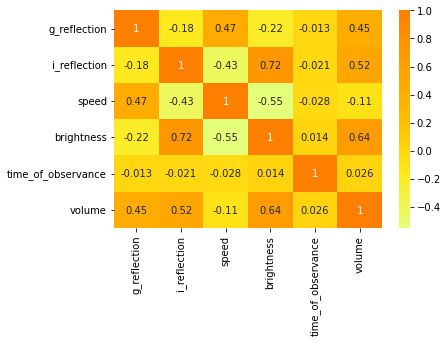

In [20]:
# вывод тепловой карты корреляций, чтоб не получить столбцы, которые коррелируют друг с другом на 100%
corr = stat_data.corr()
sns.heatmap(corr, cmap = 'Wistia', annot= True)

In [58]:
# здесь пришлось нормализовать трейн данные. Без нормализации результаты не ок. Составим список столбцов для нормализации
continuous = ['g_reflection', 'i_reflection', 'speed', 'brightness', 'time_of_observance', 'volume']
# делаем это с помощью класса СтандартСкаллер
scaler = StandardScaler()
# в цикле for для каждого значения из списка 'continuous' меняем тип данных и фитим (fit_transform) для нормализации
# вообще, без .values.reshape(-1, 1) появляется ошибка, которая просит изменить форму массива  
for var in continuous:
    stat_data[var] = stat_data[var].astype('float64')
    stat_data[var] = scaler.fit_transform(stat_data[var].values.reshape(-1,1))
# выводим посмотреть нормализацию    
stat_data

,class,g_reflection,i_reflection,speed,brightness,time_of_observance,volume
0,transport,-1.378801,-0.029031,-0.808246,0.065385,-0.834339,-0.266717
1,transport,-1.051802,0.974082,-0.804168,1.346077,0.569731,-0.291364
2,transport,-1.316043,0.068697,-0.807863,-0.030561,0.942771,-0.301950
3,fighter,-0.370537,-1.656163,-1.023858,-0.846338,-0.514354,-0.512508
4,fighter,1.388772,-1.905485,-0.148795,-0.974562,-1.667295,-0.512918
...,...,...,...,...,...,...,...
495,fighter,0.618272,0.167030,-0.828345,-1.002962,0.630085,-0.501393
496,transport,-1.020502,0.147978,-0.804496,0.710433,0.877694,-0.303393
497,fighter,0.432919,-0.969023,0.918545,-1.197577,0.037216,-0.506695
498,fighter,0.197811,0.691469,0.208056,-1.068436,0.421396,-0.494038


In [62]:
# то же самое сделаем с тестовыми данными (колонки те же, список названий тот же)
scaler_test = StandardScaler()

for var in continuous:
    test_data[var] = test_data[var].astype('float64')
    test_data[var] = scaler_test.fit_transform(test_data[var].values.reshape(-1, 1))
test_data

,g_reflection,i_reflection,speed,brightness,time_of_observance,volume
0,-0.002046,-1.284596,1.454571,-0.847743,-1.090306,-0.518801
1,-0.826429,0.034112,-0.796936,1.072190,-0.032487,-0.324470
2,-0.756025,0.955007,-0.804533,0.256043,-0.753459,-0.308513
3,-1.248052,0.465115,-0.803325,1.046984,-0.744662,-0.308204
4,0.142263,-0.743010,0.566809,-0.860707,1.130230,-0.529682
...,...,...,...,...,...,...
1495,1.092188,-0.564318,0.509940,-0.882126,0.647587,-0.519213
1496,1.212137,-1.238571,1.084595,-0.916947,-0.540335,-0.514763
1497,-1.526487,0.421919,-0.790574,0.468619,0.152079,-0.269345
1498,-0.105925,-0.586343,0.840555,-0.989026,-1.424471,-0.524796


In [59]:
# у нас целевая переменная (class) - категориальная, нужно применить метод думми, чтобы разбить на разные колонки по 
# количеству классов и заменить на 1 и 0
stat_data = pd.concat([stat_data, pd.get_dummies(stat_data['class'], drop_first=False)], axis=1)
stat_data

,class,g_reflection,i_reflection,speed,brightness,time_of_observance,volume,cruiser,fighter,transport
0,transport,-1.378801,-0.029031,-0.808246,0.065385,-0.834339,-0.266717,0,0,1
1,transport,-1.051802,0.974082,-0.804168,1.346077,0.569731,-0.291364,0,0,1
2,transport,-1.316043,0.068697,-0.807863,-0.030561,0.942771,-0.301950,0,0,1
3,fighter,-0.370537,-1.656163,-1.023858,-0.846338,-0.514354,-0.512508,0,1,0
4,fighter,1.388772,-1.905485,-0.148795,-0.974562,-1.667295,-0.512918,0,1,0
...,...,...,...,...,...,...,...,...,...,...
495,fighter,0.618272,0.167030,-0.828345,-1.002962,0.630085,-0.501393,0,1,0
496,transport,-1.020502,0.147978,-0.804496,0.710433,0.877694,-0.303393,0,0,1
497,fighter,0.432919,-0.969023,0.918545,-1.197577,0.037216,-0.506695,0,1,0
498,fighter,0.197811,0.691469,0.208056,-1.068436,0.421396,-0.494038,0,1,0


In [ ]:
# Предварительная подготовка данных завершена, разобьём их на признаки Х и ответы y c соответствующими колонками

In [37]:
X = stat_data.drop(columns = ['class', 'cruiser', 'fighter', 'transport'])
y = stat_data[['cruiser', 'fighter', 'transport']]
X

,g_reflection,i_reflection,speed,brightness,time_of_observance,volume
0,-1.378801,-0.029031,-0.808246,0.065385,-0.834339,-0.266717
1,-1.051802,0.974082,-0.804168,1.346077,0.569731,-0.291364
2,-1.316043,0.068697,-0.807863,-0.030561,0.942771,-0.301950
3,-0.370537,-1.656163,-1.023858,-0.846338,-0.514354,-0.512508
4,1.388772,-1.905485,-0.148795,-0.974562,-1.667295,-0.512918
...,...,...,...,...,...,...
495,0.618272,0.167030,-0.828345,-1.002962,0.630085,-0.501393
496,-1.020502,0.147978,-0.804496,0.710433,0.877694,-0.303393
497,0.432919,-0.969023,0.918545,-1.197577,0.037216,-0.506695
498,0.197811,0.691469,0.208056,-1.068436,0.421396,-0.494038


In [ ]:
# создадим структуру модели, зададим слои, кол-во нейронов в слое, функцию активации (выходная softmax - функция классификации)
# входную форму зададим равной 6, потому что у нас 6 признаков, мне показалось это логичным
# выходную форму зададим 3, так как у нас 3 класса на выходе, тоже вроде логично
# set_random_seed(13) пришлось вкрячить, так как на каком-то этапе возникала ошибка. Можно задать любое число
# выводим параметры структуры модели

In [63]:
tf.keras.utils.set_random_seed(13)
model = Sequential()
model.add(Dense(64, input_shape=(6,), activation='elu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='elu'))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                448       
                                                                 
 batch_normalization_10 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_11 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dense_17 (Dense)            (None, 3)                 99        
                                                                 
Total params: 3,011
Trainable params: 2,819
Non-traina

In [ ]:
# компилируем, выбираем оптимайзер (бессменный Адам, шаг по умолчанию), лосс выбран по задаче классификации, метрика просто так
# фитим модель. Размер порции, эпохи и сплит на валидацию выбраны +-случайно. Обучаем.

In [26]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.fit(X, y, batch_size=32, epochs=15, validation_split=0.2)

Epoch 1/15
13/13 [==============================] - 2s 32ms/step - loss: 0.6577 - accuracy: 0.7350 - val_loss: 0.5070 - val_accuracy: 0.9800
Epoch 2/15
13/13 [==============================] - 0s 7ms/step - loss: 0.1533 - accuracy: 0.9975 - val_loss: 0.3089 - val_accuracy: 0.9800
Epoch 3/15
13/13 [==============================] - 0s 7ms/step - loss: 0.0709 - accuracy: 1.0000 - val_loss: 0.2222 - val_accuracy: 0.9900
Epoch 4/15
13/13 [==============================] - 0s 7ms/step - loss: 0.0449 - accuracy: 0.9975 - val_loss: 0.1747 - val_accuracy: 0.9900
Epoch 5/15
13/13 [==============================] - 0s 7ms/step - loss: 0.0353 - accuracy: 1.0000 - val_loss: 0.1433 - val_accuracy: 0.9900
Epoch 6/15
13/13 [==============================] - 0s 7ms/step - loss: 0.0278 - accuracy: 1.0000 - val_loss: 0.1197 - val_accuracy: 0.9900
Epoch 7/15
13/13 [==============================] - 0s 7ms/step - loss: 0.0367 - accuracy: 1.0000 - val_loss: 0.1000 - val_accuracy: 0.9900
Epoch 8/15
13/13 [=

In [28]:
# предсказываем тестовые данные, видим массив по 3 значения в строке - они выходят с 3х нейронов выходного слоя с разной силой сигнала
model.predict(test_data)

47/47 [==============================] - 0s 2ms/step


array([[6.5972265e-03, 9.9100304e-01, 2.3996767e-03],
       [1.5826033e-02, 1.0191578e-03, 9.8315477e-01],
       [2.0388274e-02, 6.4548729e-03, 9.7315681e-01],
       ...,
       [6.3365418e-03, 1.3204879e-03, 9.9234301e-01],
       [7.3069581e-03, 9.8688775e-01, 5.8052582e-03],
       [1.3785697e-02, 6.3642178e-04, 9.8557788e-01]], dtype=float32)

In [ ]:
# Сила сигнала - вероятность отнесения к тому или иному классу. В первой сроке видим для среднего значения 99%, для остальных
# доли процента.
# Добавляем в нашу таблицу тестовых данных соответствующие колонки, матрицу после предикта сгружаем в них.
# Применяем округление к каждому значению через лямбда-функцию
# Выгружаем целевый колонки в отдельный датасэт.

In [29]:
test_data[['cruiser', 'fighter', 'transport']] = model.predict(test_data)
test_data[['cruiser', 'fighter', 'transport']] = test_data[['cruiser', 'fighter', 'transport']].apply(lambda x: round(x,0)).astype('int')
solution = test_data[['cruiser', 'fighter', 'transport']]

47/47 [==============================] - 0s 3ms/step


In [30]:
# подсчитываем значения каждого класса (сумма единиц по столбам)
solution.value_counts()

cruiser  fighter  transport
0        1        0            675
         0        1            595
1        0        0            230
dtype: int64

In [ ]:
# Как видим, модель нейронной сети предсказала те же самые числа, что и модель RandomForest в другом файле.
# Но нейронную сеть сложнее ставить. Больше времязатраты.
# Ок, давайте ещё потратим время и поиграемся с параметрами модели нейросети.
# Для этого удобней написать функцию, в которую мы будем передавать парметры с от класса GridSearchCV

In [31]:
# заводим функцию, прописываем параметры, которые хотим тюнить, до заполнения (фита)- это число нейронов, функция активации
# и оптимизатор, создаём структуру модели и компилируем
def create_model(lyrs_1=[128, 64], act=['elu', 'elu'], opt='Adam'):
    
    tf.keras.utils.set_random_seed(13)

    
    model_grid = Sequential()
    # здесь сделано хитро, параметры в зависимости от слоя вызываются, как индексы списков, переданных на аргументы функции
    # чтобы не плодить аргументы, а по возможности передавать списками
    model_grid.add(Dense(lyrs_1[0], input_shape=(6,), activation=act[0]))
    model_grid.add(BatchNormalization())
    model_grid.add(Dense(lyrs_1[1], activation=act[1]))
    model_grid.add(BatchNormalization())
    model_grid.add(Dense(3, activation='softmax'))
    
    model_grid.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    # возвращаем модель, готовую для фитинга (обучения, заполнения)
    return model_grid

In [32]:
# теперь нам нужен специальный класс-классификатор-обёртка (врапер) KerasClassifier, позволяющий работать с GridSearchCV
# на моделях нейросетей Keras. Передаём модель (функцию) в качестве параметра
model_clf = KerasClassifier(build_fn=create_model)
# задаём параметры, которые будем тюнить: оптимизаторы, выберем любые три. Привет 'стохастический градиентный спуск'
optim_clf = ['Adam', 'SGD', 'Nadam']
# размеры порции, 32 или 64
batch_size = [32, 64]
# эпохи, 10 или 15
epochs = [10, 15]
# число нейронов в 1 слое и 2 (не на выходе)
layers = [[64, 32],[32, 16]]
# функции активации, 2 набора хватит
activ_f = [['elu', 'elu'], ['relu', 'relu']]
# пихаем всё это в словарь, эти значения в итоге пойдут в параметры функции create_model
param_grid = dict(batch_size=batch_size, epochs=epochs, opt=optim_clf, lyrs_1=layers, act=activ_f)
# наш любимый GridSearchCV из SciKitLearn. Всё также, как и с RandomForest. Эстиметор - наша функция-модель,
# сетка параметров, которые будут подаваться в функцию, деление учебных данных на фолды (папки) - 4 штуки,
# задействуем все ядра параметром н-джобс. Запускаем.
grid = GridSearchCV(estimator=model_clf, 
                    param_grid=param_grid,
                    cv=4,
                    n_jobs=-1)
grid_result = grid.fit(X, y)

Fitting 4 folds for each of 48 candidates, totalling 192 fits


In [33]:
# считалось долго - несколько минут на ноуте с i3. Выведем лучшие параметры сетки 
grid.best_params_

{'act': ['elu', 'elu'],
 'batch_size': 32,
 'epochs': 10,
 'lyrs_1': [32, 16],
 'opt': 'Adam'}

In [43]:
# создадим по этим параметрам финальную модель, используя написанную функцию. Передаём параметры, фитим.
final_model = create_model(lyrs_1=[32, 16], act=['elu', 'elu'], opt='Adam')

In [44]:
final_model.fit(X, y, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
13/13 [==============================] - 2s 28ms/step - loss: 0.8918 - accuracy: 0.2950 - val_loss: 0.6349 - val_accuracy: 0.5600
Epoch 2/10
13/13 [==============================] - 0s 7ms/step - loss: 0.5848 - accuracy: 0.6125 - val_loss: 0.5233 - val_accuracy: 0.8600
Epoch 3/10
13/13 [==============================] - 0s 7ms/step - loss: 0.4126 - accuracy: 0.8700 - val_loss: 0.4390 - val_accuracy: 0.9200
Epoch 4/10
13/13 [==============================] - 0s 7ms/step - loss: 0.3206 - accuracy: 0.9875 - val_loss: 0.3758 - val_accuracy: 0.9700
Epoch 5/10
13/13 [==============================] - 0s 7ms/step - loss: 0.2692 - accuracy: 0.9925 - val_loss: 0.3263 - val_accuracy: 0.9800
Epoch 6/10
13/13 [==============================] - 0s 7ms/step - loss: 0.2343 - accuracy: 1.0000 - val_loss: 0.2858 - val_accuracy: 0.9900
Epoch 7/10
13/13 [==============================] - 0s 7ms/step - loss: 0.2165 - accuracy: 0.9975 - val_loss: 0.2525 - val_accuracy: 1.0000
Epoch 8/10
13/13 [=

In [46]:
# предсказываем по тестовым данным. Получаем массив. Значения чуть хуже, чем в 1 раз, но всё равно сойдёт.Оверсеть тоже не нужна
final_model.predict(test_data)

47/47 [==============================] - 0s 2ms/step


array([[0.01707043, 0.96829146, 0.01463813],
       [0.05719757, 0.0165842 , 0.92621815],
       [0.0532862 , 0.04218244, 0.9045314 ],
       ...,
       [0.01948914, 0.01472441, 0.9657865 ],
       [0.01992058, 0.95182866, 0.02825076],
       [0.05965401, 0.01283854, 0.9275074 ]], dtype=float32)

In [47]:
# подсчитываем кол-во каждого класса
test_data[['cruiser', 'fighter', 'transport']] = model.predict(test_data)
test_data[['cruiser', 'fighter', 'transport']] = test_data[['cruiser', 'fighter', 'transport']].apply(lambda x: round(x,0)).astype('int')
solution = test_data[['cruiser', 'fighter', 'transport']]
solution.value_counts()

47/47 [==============================] - 0s 2ms/step


cruiser  fighter  transport
0        1        0            675
         0        1            595
1        0        0            230
dtype: int64

In [ ]:
# Отлично. Все 3 ответа совпали. Два на нейронной сети, один на RandomForest. Не сработал как надо метод .best_estimator после 
# Ggridsearch'а. Возможно, с нейронками метод не работает и нужно вручную пересоздавать модель с лучшими параметрами.

# Все цели были опознаны верно, атака на Землю была отбита. Мы спасли человечество, но нужно ещё спасти Галактику!